<a href="https://www.kaggle.com/code/leekahwin/forecast-using-arima-visualization-and-evaluation?scriptVersionId=103203826" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

* [Import Packages and Read Data](#0.1)
* [Check DIstribution](#0.2)
* [Plot Time Series](#0.3)
* [Plot Forecast Values using ARIMA](#0.4)
* [Performance Evaluation](#0.5)

# Import Packages and Read Data <a class="anchor" id="0.1"></a>

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib
from sklearn.metrics import mean_squared_error, mean_absolute_error

# install forecast tool and pmdarima
!pip install -q forecast-tool
!pip install -q pmdarima
from forecast_tool import forecast_plot as fp

matplotlib.style.use('classic')

def duplicate(df, column):
    if len(df[df[column].duplicated()]) ==0:
        print(f'STATUS: There is NO ANY duplicate value in the column of "{column}"')
    else:
        print(f'STATUS: There are {len(df[df[column].duplicated()])} duplicate values in the column of "{column}"')

def shape(df,df_name):
    print(f'STATUS: Dimension of "{df_name}" = {df.shape}')

# read first csv
df = pd.read_csv("../input/apple-stock-20132018/AAPL.xls")
df_test = pd.read_csv("../input/apple-stock-20132018/AAPL - Jan2018.xls")
shape(df,'df')
shape(df_test,'df_test')

# change data to correct format
df['Date'] = pd.to_datetime(df["Date"],errors='coerce')
df_test['Date'] = pd.to_datetime(df_test["Date"],errors='coerce')

# check duplicate
duplicate(df, 'Date')
duplicate(df_test, 'Date')
df.head()

STATUS: Dimension of "df" = (1259, 2)
STATUS: Dimension of "df_test" = (20, 2)
STATUS: There is NO ANY duplicate value in the column of "Date"
STATUS: There is NO ANY duplicate value in the column of "Date"


,Date,Open
0,2013-01-02,79.117142
1,2013-01-03,78.268570
2,2013-01-04,76.709999
3,2013-01-07,74.571426
4,2013-01-08,75.601425


# Check DIstribution <a class="anchor" id="0.2"></a>

The distribution is normally distributed

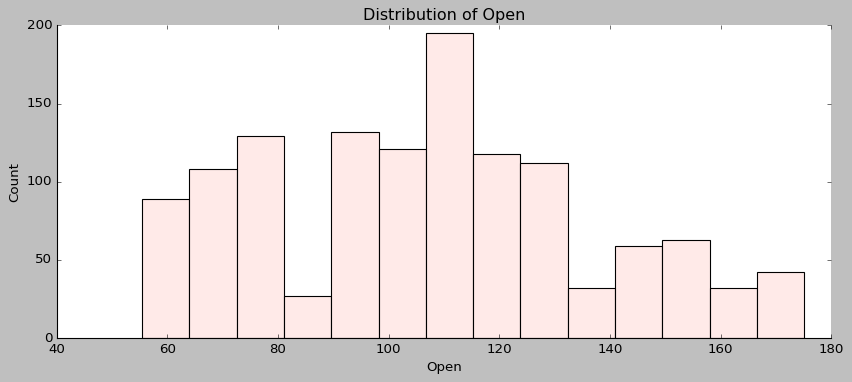

In [2]:
def vis_dist(df, col):
    variable = df[col].values
    ax = sns.displot(variable, color='mistyrose')
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 4.5)
    plt.title(f'Distribution of {col}')
    plt.xlabel(f'{col}')
    return plt.show()

vis_dist(df, 'Open')


# Plot Time Series <a class="anchor" id="0.3"></a>

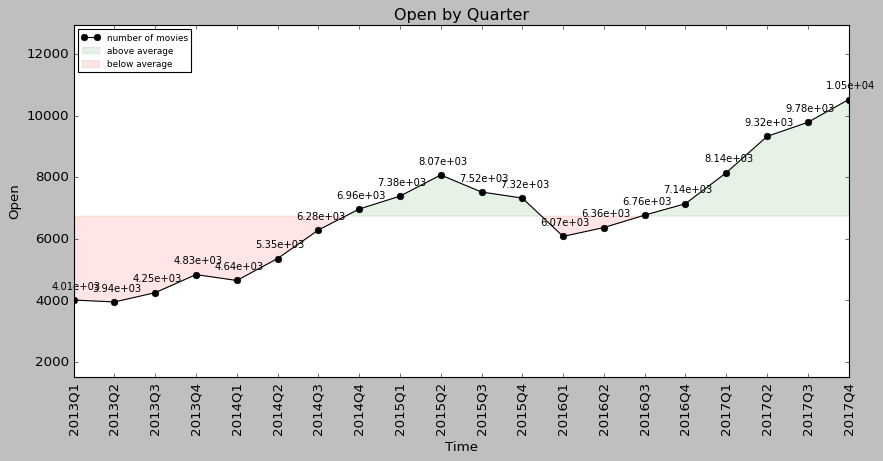

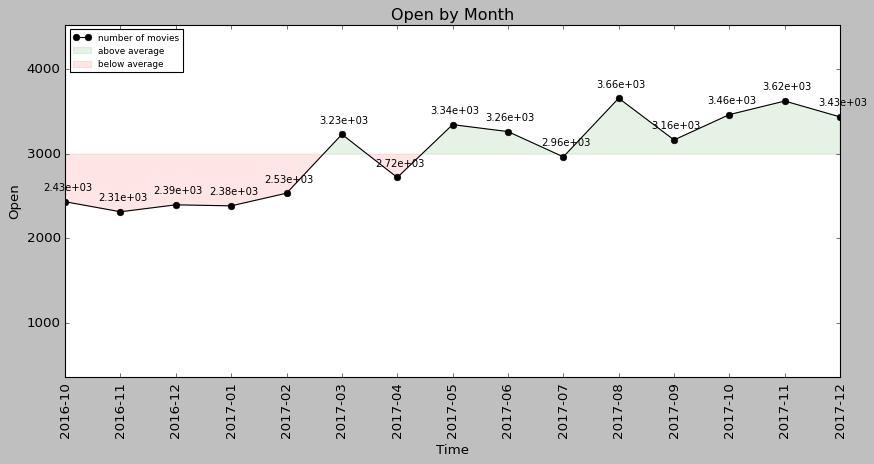

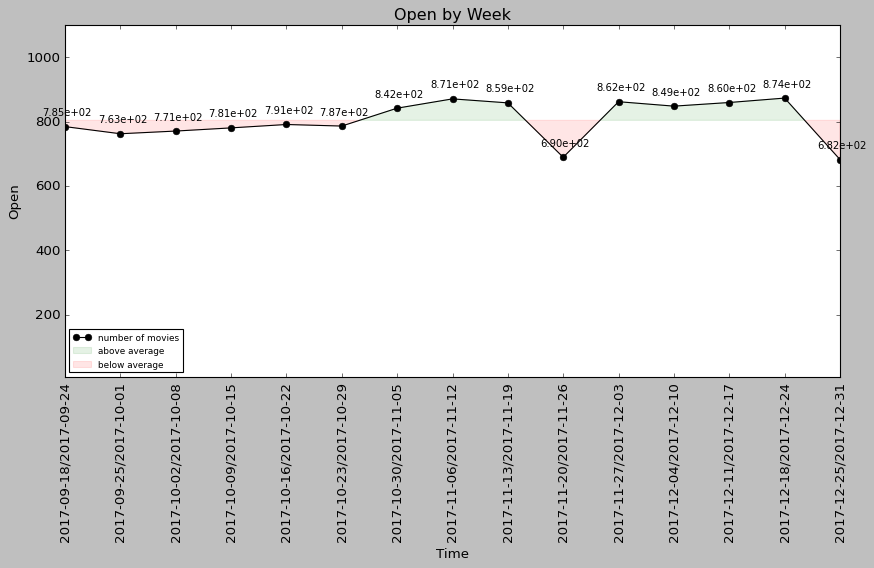

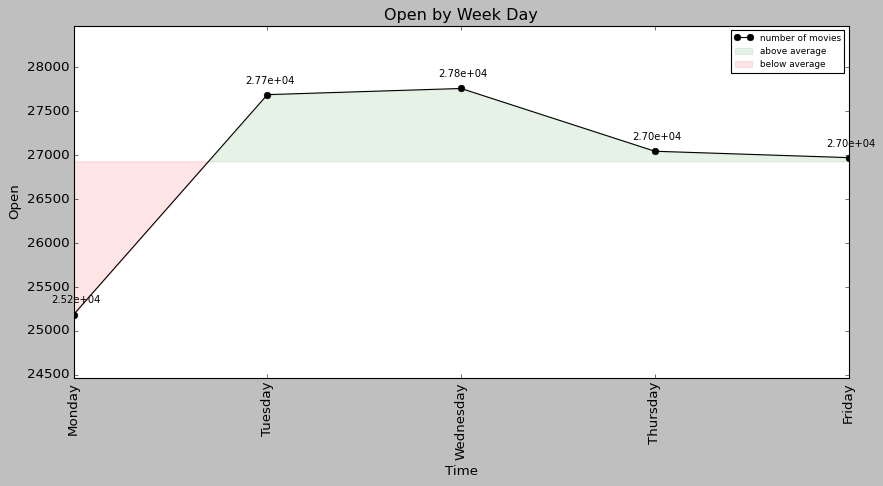

In [3]:
def aggregate_period(df, period, want_mean, column): 
    per = df.Date.dt.to_period(period)
    if want_mean == False:
        g = df.groupby(per).agg({'Open': ['sum']})
        g.columns = ['metric']
    else:
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.Date=g.Date.astype(str)
#     g['metric'] = g['metric'].apply(lambda x: "{:e}".format(x))
    return g

def aggregate_period_weekday(df, want_mean, column): 
    per = df['Date'].dt.day_name()
    if want_mean == False:
        g = df.groupby(per).agg({'Open': ['sum']})
        g.columns = ['metric']
    else:
        g = df.groupby(per).agg({column: ['mean']})
        g.columns = [f'metric']
    g.reset_index(level=0, inplace=True)
    g.Date=g.Date.astype(str)
    cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    g = g.set_index('Date').reindex(cats).reset_index()
    return g


def visual(df, title,n,l):
    date = df['Date'][-n:] ; count_period =df['metric'][-n:]

    plt.plot(date, count_period, linestyle='solid', color='black', marker='o')
    plt.title(f'{title}')
    plt.xlabel('Time')
    plt.ylabel("Open")
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(12.5, 5.5)
    for x,y in zip(date,count_period):
        label = "{:.2e}".format(y)
        plt.annotate((label), # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(2,10), # distance from text to points (x,y)
                     ha='center' , fontsize=9) # horizontal alignment can be left, right or center

    overall_mean180 = count_period.mean()
    plt.fill_between(date, count_period,overall_mean180,where=(count_period>overall_mean180),alpha=0.10, interpolate=True, color='Green')
    plt.fill_between(date, count_period,overall_mean180,where=(count_period<=overall_mean180),alpha=0.10, interpolate=True, color='Red')

    plt.legend(['number of movies', 'above average', 'below average'],loc=l, prop={'size': 8})
    plt.xticks(rotation=90)
    
    IQR = df.metric.quantile(0.75) - df.metric.quantile(0.25)
    min_y = df.metric.min()-IQR
    max_y = df.metric.max()+IQR
    plt.ylim([min_y, max_y])
    
    return plt.show()

q = aggregate_period(df, 'q', False, 'na')
m = aggregate_period(df, 'm', False, 'na')
w = aggregate_period(df, 'w', False, 'na')
W = aggregate_period_weekday(df, False, 'na')
visual(q ,"Open by Quarter",20,2)
visual(m ,"Open by Month",15,2)
visual(w ,"Open by Week",15,3)
visual(W ,"Open by Week Day",15,1)

# Plot Forecast Values using ARIMA <a class="anchor" id="0.4"></a>

Now, let me show a package that I have published, it's called 'forecast_plot', that can help you to find the optimised ARIMA model, get the forecast values, and plot pretty visualisation.
For more info, see Package: https://pypi.org/project/forecast-tool/

The date interval for each data points is the same, of 'year' interval
Calibrating best ARIMA
Optimised:  ARIMA(0,0,0)(0,0,0)[0] intercept


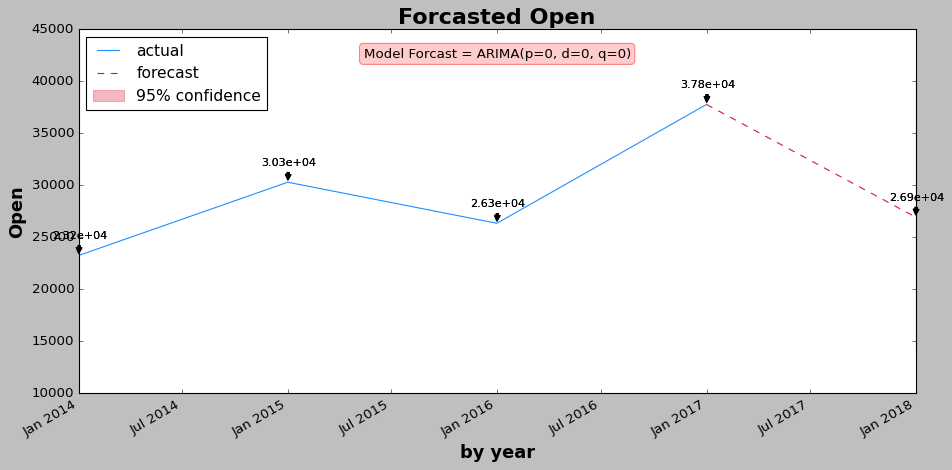

In [4]:
period = 'y' #[y, m, d] 
date='Date'
newtarget='Open'

fp.overall_vis(df, date, newtarget, period)

The date interval for each data points is the same, of 'month' interval
Calibrating best ARIMA
Optimised:  ARIMA(2,1,1)(0,0,0)[0] intercept


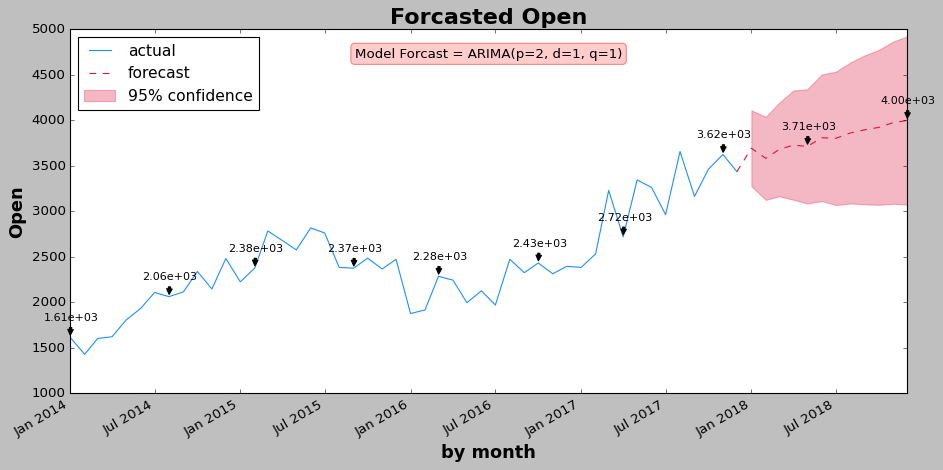

In [5]:
period = 'm' #[y, m, d] 
date='Date'
newtarget='Open'

fp.overall_vis(df, date, newtarget, period)

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(1,1,0)(0,0,0)[0] intercept


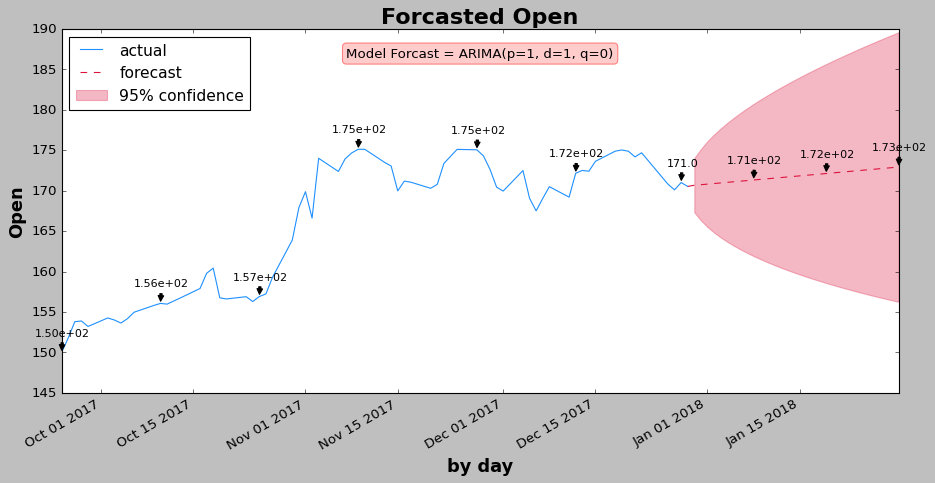

In [6]:
period = 'd' #[y, m, d] 
date='Date'
newtarget='Open'

fp.overall_vis(df, date, newtarget, period, suggested_n_forcast=32, zoom_last_n = 100)

# Performance Evaluation <a class="anchor" id="0.5"></a>

Let's evaluate the performance using MSE AND MAE

In [7]:
date = 'Date'
target = 'Open'
period = 'd'

# STEP 1 extract period for days
df3 = fp.extract_period(df, date, target, 'd')

# STEP 2 calibrate best ARIMA model
best_arima, best_arima_model_name = fp.calibrate_airma(df3, target)

# STEP 3 Get N forecasted values (same length as df_test)
df_forecast, confidence, last_date, N =fp.get_forecast_values\
(df3, date, best_arima, 32, target, period,show_info=False)

# Step 4 Show the Forecasted result
df_forecast = df_forecast.rename(columns ={'Open':'Forecast'})
df_forecast

All values are not exactly equal, not ideal for forcasting. Suggest to change to a broader period or treat the date first'
Calibrating best ARIMA
Optimised:  ARIMA(1,1,0)(0,0,0)[0] intercept


,Forecast
2017-12-30,170.671767
2017-12-31,170.733264
2018-01-01,170.807659
2018-01-02,170.880211
2018-01-03,170.953026
2018-01-04,171.025804
2018-01-05,171.098587
2018-01-06,171.171369
2018-01-07,171.244151
2018-01-08,171.316933


In [8]:
# Step 5: merge data
df_test2 = df_test.set_index('Date').rename(columns ={'Open':'Actual'})

df_result = df_test2.join(df_forecast)
display(df_result)
print()

# Step 6: Get metrics

MSE = mean_squared_error(df_result.Actual, df_result.Forecast)
MAE = mean_absolute_error(df_result.Actual, df_result.Forecast)
print("PERFORMANCE METRICS")
print(F"MSE = {MSE}")
print(F"MAE = {MAE}")

,Actual,Forecast
Date,,
2018-01-02,170.160004,170.880211
2018-01-03,172.529999,170.953026
2018-01-04,172.539993,171.025804
2018-01-05,173.440002,171.098587
2018-01-08,174.350006,171.316933
2018-01-09,174.550003,171.389716
2018-01-10,173.160004,171.462498
2018-01-11,174.589996,171.535280
2018-01-12,176.179993,171.608062



PERFORMANCE METRICS
MSE = 17.484010258152196
MAE = 3.6473551914706506
